In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import data_cleaning

# Summary

This is an analysis originated from a bounty from [DiamondDAO](https://docs.diamonddao.xyz/welcome/values) that aims to analyze the data coming form ETH Denver attendees and their pathway in crypto after the event.

**Main objective:** 
- To determine the profile of inviduals attending the event.
- To understand the impacts of the event in the ecosystem. 

# Data loading

In [2]:
#POAP data
poap = data_cleaning.get_cleaned_poap_data()

#DAOHaus data
dh_members, dh_votes, dh_proposals = data_cleaning.get_daohaus_cleaned_data()

#Snapshot data
snap_proposals, snap_votes = data_cleaning.get_snapshot_cleaned_data()

#Token balance data

spork = data_cleaning.get_token_holder_cleaned_data()

# Analysis

## ETH Denver POAP Overview

### **Mints**

##### Table #### 

   event_year  n_unique_users  total_tokens_minted
0        2018              27                   27
1        2019              84                   87
2        2020             243                  274
3        2021             740                 5066
4        2022               2                    2


################ 


Number of unique minter addresses per year & total numbers of tokens minted (for ALL ETH Denver related POAPs)


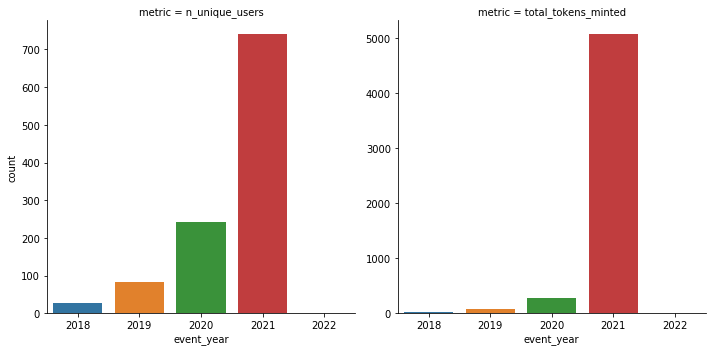

In [36]:
mints = poap.loc[(poap.event_name.str.contains('ethdenver', case=False) )&
                (poap.owner_id != "0x0000000000000000000000000000000000000000")].copy()

mints_year = mints.groupby('event_year').agg(n_unique_users=('owner_id', 'nunique'), 
                                             total_tokens_minted=('token_id', 'nunique')).reset_index()

mints_melt = pd.melt(mints_year, id_vars=['event_year'], value_vars=['n_unique_users', 'total_tokens_minted'], 
                                                         var_name='metric', value_name='count')

print('##### Table #### \n')
print(mints_year)
print('\n')
print('################ \n\n')

print('Number of unique minter addresses per year & total numbers of tokens minted (for ALL ETH Denver related POAPs)')
sns.catplot(data=mints_melt, x='event_year', y='count', col='metric', kind='bar', sharey=False)

plt.show()

**Comment**: The numbers of unique minter addresses in consistently increasing, and it seems 2021 was a huge leap. This is also reflected in the total amount of tokens minted, where this effect in even drastic.

### **POAP loyal minters**

In [37]:
# count of users with X amount of years
lominters = mints.groupby('owner_id').agg(n_years_minted=('event_year', 'nunique')).reset_index()
lominters_group = lominters.groupby('n_years_minted').agg(unique_user_count=('owner_id', 'nunique'))
lominters_group['%'] = (lominters_group['unique_user_count'] / lominters_group['unique_user_count'].sum()) * 100

lominters_group

,unique_user_count,%
n_years_minted,,
1,978,94.675702
2,49,4.743466
3,4,0.387222
4,2,0.193611


**Comment:** Kind of makes sense once most people started gong on 2021. What about this % but considering when people started? 

In [38]:
# count of users with X amount of years
lominters = mints.groupby(['owner_id']).agg(n_years_minted=('event_year', 'nunique'), 
                                            year_started=('event_year', 'min')).reset_index()
lominters_group = lominters.groupby(['year_started','n_years_minted']).agg(unique_user_count=('owner_id', 'nunique'))
lominters_group['%'] = (lominters_group['unique_user_count'] / lominters_group.groupby(level=0).transform('sum')['unique_user_count']) * 100

lominters_group

unique_user_count           %
year_started n_years_minted                               
2018         1                               4   14.814815
             2                              18   66.666667
             3                               3   11.111111
             4                               2    7.407407
2019         1                              49   76.562500
             2                              14   21.875000
             3                               1    1.562500
2020         1                             207   92.410714
             2                              17    7.589286
2021         1                             716  100.000000
2022         1                               2  100.000000

**Comment**: We could say that the turnover rate here (% of people that just go to the event one time) seems to be increasing over time. This inherentely means that the retention rate is going lower.

Limitations of this specific table: 
- As the number of attendes increase, we can have more one-time enthusiats that are only going due to crypto price action / curiosity.
- A LOT of attendees might not redeem their POAPs at all or maybe redeem POAPs in different wallets, which might led to this number increasing.
- As we get closer to recent years, the fewer chances "newer" people have to attend to new events (so with time retention might go up for recent years with time)

### **What is the impact of ETH Denver attendance to other events?**

In [42]:
lominters = lominters.rename(columns={'n_years_minted': 'EthDenver_n_years_minted', 
                                     'year_started': 'EthDenver_first_year'})

poap = poap.merge(lominters, on='owner_id', how='left')

difevs = poap.loc[(~poap.event_name.str.contains('ethdenver', case=False)) &
                 (poap['EthDenver_n_years_minted'].notnull())].copy()

# Normalizing ETH Denver POAPs once that it seems multiple POAP were emitted during each unique events
ethdenver_normalizer = mints.loc[:, ['event_id', 'event_name', 'event_year']].drop_duplicates('event_id')
ethdenver_normalizer['event_name_normalized'] = ethdenver_normalizer['event_year'].apply(lambda y: f"ETHDenver_{y}")

poap = poap.merge(ethdenver_normalizer.loc[:, ['event_id','event_name_normalized']], on='event_id', how='left')
poap.loc[poap.event_name_normalized.isnull(), 'event_name_normalized'] = poap.event_name

#### How is average attendance from ETH Denver attendees compared to non-attendees?

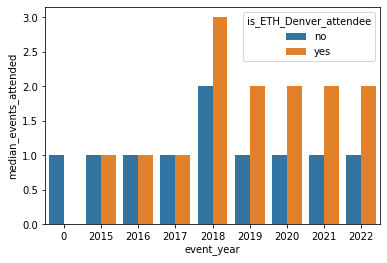

In [71]:
poap['is_ETH_Denver_attendee'] = 'no'
poap.loc[poap['EthDenver_n_years_minted'].notnull(), 'is_ETH_Denver_attendee'] = 'yes'

denvcomp = poap.groupby(['owner_id','is_ETH_Denver_attendee','event_year']).agg(n_events_attended=('event_name_normalized', 'nunique')).reset_index()
denvcomp_group = denvcomp.groupby(['is_ETH_Denver_attendee', 'event_year']).agg(median_events_attended=('n_events_attended','median')).reset_index()

sns.barplot(data=denvcomp_group, x='event_year', y='median_events_attended', hue='is_ETH_Denver_attendee')
plt.show()

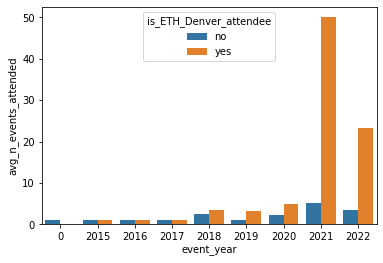

In [76]:
poap['is_ETH_Denver_attendee'] = 'no'
poap.loc[poap['EthDenver_n_years_minted'].notnull(), 'is_ETH_Denver_attendee'] = 'yes'

denvcomp = poap.groupby(['owner_id','is_ETH_Denver_attendee','event_year']).agg(n_events_attended=('event_name_normalized', 'nunique')).reset_index()
denvcomp_group = denvcomp.groupby(['is_ETH_Denver_attendee', 'event_year']).agg(avg_n_events_attended=('n_events_attended','mean')).reset_index()

sns.barplot(data=denvcomp_group, x='event_year', y='avg_n_events_attended', hue='is_ETH_Denver_attendee')
plt.show()

**Comment**: as we can see from both graphs above, ETH Denver attendees seem to be more active in events (at list from the POAP minting aspect of it). Also from the difference between median (first graph) and mean (second), the number of events attended is highly skewed where few people participate in a lot of events, while a median person would attend 2-1 event a year.

#### What happens after first attendance to ETH Denver?

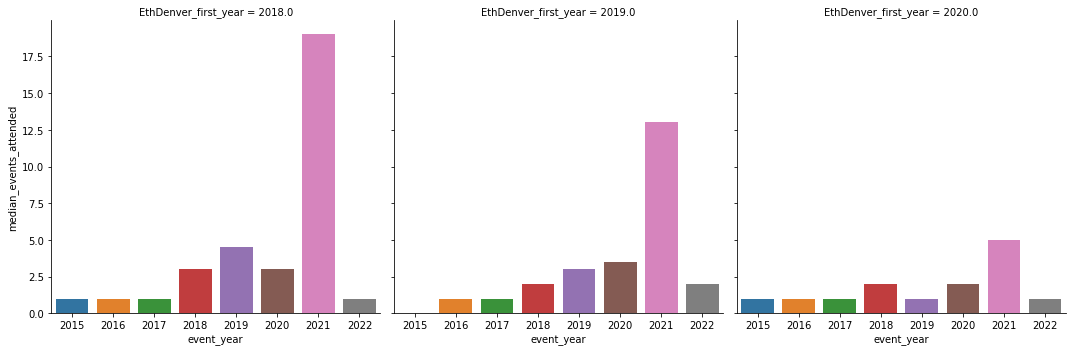

In [75]:
fist_attendance_raw = difevs.groupby(['owner_id','EthDenver_first_year', 'event_year']).agg(
                                                                                    n_unique_events=('event_name_normalized', 'nunique')).reset_index()

first_attendance_group = fist_attendance_raw.groupby(['EthDenver_first_year', 'event_year']).agg(
                                                                                    median_events_attended=('n_unique_events', 'median')).reset_index()


fatg = first_attendance_group.loc[(first_attendance_group['EthDenver_first_year'].isin([2018, 2019, 2020]))].copy()

sns.catplot(data=fatg, x='event_year', y='median_events_attended', col='EthDenver_first_year', kind='bar')


**Comment**: It seems that 2021 was a boom in events attended for all types of ETH Denver recurrent attendes. It seems that after 2018, there is a postive trend for all groups that is stronger than ETH Denver itself. 

#### What are the most popular events that ETH Denver attendees also go to? 

In [82]:
nondenver = poap.loc[(~poap.event_name_normalized.str.contains('ethdenver', case=False))&
                    (poap.is_ETH_Denver_attendee=='yes')].copy()

nondenver_g = nondenver.groupby(['event_year', 'event_name_normalized']).agg(attendee_count=('owner_id', 'nunique')).reset_index()
nondenver_g = nondenver_g.sort_values(['event_year','attendee_count'], ascending=[True, False])

nondenver_g.groupby('event_year').head(5).sort_values(['event_year','attendee_count'], ascending=[True, False])

,event_year,event_name_normalized,attendee_count
0,2015,DevCon1,5
1,2016,DevCon2,13
2,2016,Devcon2 by Piper Merriam,2
3,2017,DevCon3,26
6,2018,DevCon4,52
9,2018,ETHBerlin,32
7,2018,EDCON,23
13,2018,ETHSanFrancisco,23
14,2018,EthCC,23
35,2019,Devcon5,77


## Merging POAP minters with SPORK holder data

In [ ]:
# Check all ETH Denver POAP recipients


# Cross reference POAP holders and SPORK holders
## make analysis on how many of the the POAP issuers have token of the opposite - which parameters identify the most people?





In [ ]:
# Isolate all possible ETH Denver participants and start looking at DAO cross reference like:
## how many DAOs can the person be identified at (DAOHaus)
## how many proposals or votes this people have? once you have proposals or votes this would add you as member of the DAO
## explore the concept of stronger membership and weak membership attached to how much people participate 
## explore level of activity
### how many votes
### how many different DAOs
### total number of interactions vs count of specific reactions: vote, proposals, etc
### what is the SPORK holders share in the votes in snapshot - what is their wight on these things? vs only POAP vs general public
